# Comapre BALD, EPIG, ECFP for ECFP, and BERT

In [1]:
import sys
sys.path.insert(1, '/projects/home/mmasood1/TG GATE/active_learning')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from utils.data_utils import get_random_query_set, get_query_set, update_training_set, remove_queried_index_from_pool_set

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/mmasood1/.conda/envs/env_arslan/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
def get_results(model_dir, itteration):
    seed_list = [42, 0, 88, 100, 142]
    results_all = pd.DataFrame()
    for seed in seed_list:
        for itteration in range(num_itterations):
            try:
                result_itteration = pd.read_csv(model_dir + f"/Results/itteration_{itteration}_metrics_itteration_{itteration}_s{seed}_alpha_0.0_gamma_0.0_loss_type_BCE_λ0.01.csv")
                result_itteration.insert(0, "Itteration", itteration)
                result_itteration.insert(0, "seed", seed)
                results_all = pd.concat([results_all, result_itteration], axis = 0)
            except:
                pass
    return results_all

def get_sample_data(result_dir,selected_tasks,num_itterations):
    initial_set = pd.read_csv(result_dir + f"{selected_tasks}/query_set/initial_set.csv")
    training_set = initial_set.copy()

    pos, neg = [], []

    for itteration in range(num_itterations):
        pos.append((training_set[selected_tasks] == 1).sum())
        neg.append((training_set[selected_tasks] == 0).sum())
        query_set = pd.read_csv(result_dir + f"{selected_tasks}/query_set/query_set_itteration_{itteration}_s42_alpha_0.0_gamma_0.0_loss_type_BCE_λ0.01.csv")
        training_set = update_training_set(training_set, query_set)

    sample_data = pd.DataFrame({"pos": pos,
                                "neg": neg})
    sample_data["valid"] =   sample_data["pos"] + sample_data["neg"]  
    sample_data["Itteration"] =   range(num_itterations)                      
                    
    return sample_data


In [4]:
def combine_results(config, features, task_wise_mean = True):
    Uniform_BERT,BALD_BERT,EPIG_BERT = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for task in all_tasks:
        print(task)
        Uniform_b = get_results(config[f"Uniform_{features}_dir"] + task, num_itterations)
        BALD_b = get_results(config[f"BALD_{features}_dir"] + task, num_itterations)
        EPIG_b = get_results(config[f"EPIG_{features}_dir"] + task, num_itterations)

        # BERT
        Uniform_b = Uniform_b[Uniform_b.Tasks == task]
        BALD_b = BALD_b[BALD_b.Tasks == task]
        EPIG_b = EPIG_b[EPIG_b.Tasks == task]

        Uniform_BERT = pd.concat([Uniform_BERT,Uniform_b], axis = 0)
        BALD_BERT = pd.concat([BALD_BERT,BALD_b], axis = 0)
        EPIG_BERT = pd.concat([EPIG_BERT,EPIG_b], axis = 0)


    if task_wise_mean:
        Uniform_BERT = Uniform_BERT.groupby(["Itteration","seed"]).mean(numeric_only = True).reset_index()
        BALD_BERT = BALD_BERT.groupby(["Itteration","seed"]).mean(numeric_only = True).reset_index()
        EPIG_BERT = EPIG_BERT.groupby(["Itteration","seed"]).mean(numeric_only = True).reset_index()

    Uniform_BERT["Acq_Func"] = f"{features}_Uniform"
    BALD_BERT["Acq_Func"] = f"{features}_BALD"
    EPIG_BERT["Acq_Func"] = f"{features}_EPIG"

    result_data = pd.concat([Uniform_BERT,BALD_BERT,EPIG_BERT])
    result_data["Features"] = features
    return result_data

In [5]:
def combine_samples(config, features):
    Uniform_BERT,BALD_BERT,EPIG_BERT = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for task in all_tasks:

        Uniform_b = get_sample_data(config[f"Uniform_{features}_dir"], task, num_itterations)
        BALD_b = get_sample_data(config[f"BALD_{features}_dir"],task, num_itterations)
        EPIG_b = get_sample_data(config[f"EPIG_{features}_dir"], task, num_itterations)

        Uniform_BERT = pd.concat([Uniform_BERT,Uniform_b], axis = 0)
        BALD_BERT = pd.concat([BALD_BERT,BALD_b], axis = 0)
        EPIG_BERT = pd.concat([EPIG_BERT,EPIG_b], axis = 0)

    Uniform_BERT["Acq_Func"] = f"{features}_Uniform"
    BALD_BERT["Acq_Func"] = f"{features}_BALD"
    EPIG_BERT["Acq_Func"] = f"{features}_EPIG"

    result_data = pd.concat([Uniform_BERT,BALD_BERT,EPIG_BERT])
    result_data["Features"] = features
    return result_data

In [6]:
config = {"target_file": "/projects/home/mmasood1/arslan_data_repository/Tox21/complete_Tox21.csv",
          "Uniform_BERT_dir":"/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/uniform/",
          "BALD_BERT_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/BALD/",
          "EPIG_BERT_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/EPIG_MT/",
          
          "Uniform_ECFP_dir":"/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/ECFP/uniform/",
          "BALD_ECFP_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/ECFP/BALD/",
          "EPIG_ECFP_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/ECFP/EPIG_MT/",
          
          "Uniform_BERT_Tox21_dir":"/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/uniform/",
          "BALD_BERT_Tox21_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/BALD/",
          "EPIG_BERT_Tox21_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/EPIG_MT/",}

data = pd.read_csv(config["target_file"])  
data.drop("SMILES", axis = 1, inplace = True)   
all_tasks = data.loc[:, "NR-AR":"SR-p53"].columns.tolist()

num_itterations = 200
BERT_Vanilla = combine_results(config, "BERT")
ECFP_Vanilla = combine_results(config, "ECFP")
BERT_Tox21 = combine_results(config, "BERT_Tox21")

NR-AR


NR-AR-LBD
NR-AhR
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53
NR-AR
NR-AR-LBD
NR-AhR
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53
NR-AR
NR-AR-LBD
NR-AhR
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53


In [15]:
data.sum(axis = 0) / data.shape[0]

NR-AR            0.039459
NR-AR-LBD        0.030264
NR-AhR           0.098072
NR-Aromatase     0.038309
NR-ER            0.101264
NR-ER-LBD        0.044694
NR-PPAR-gamma    0.023752
SR-ARE           0.120291
SR-ATAD5         0.033712
SR-HSE           0.047504
SR-MMP           0.117226
SR-p53           0.054016
dtype: float64

7831

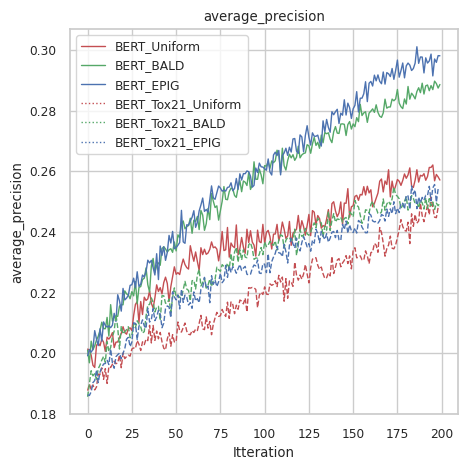

In [8]:
metrics_list = ["average_precision"]
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
sns.set(font_scale=0.8)  # crazy big
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )

for i, metric in enumerate(metrics_list):
    sns.lineplot(data = BERT_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "-", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )
    

    sns.lineplot(data = BERT_Tox21, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "--", 
                palette=['r', 'g','b'], lw = 1, errorbar = None #"se"
                )

    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    ax.set_title(metric)

leg = ax.legend(loc = "upper left")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle(":")
leg_lines[4].set_linestyle(":")
leg_lines[5].set_linestyle(":")


#fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_average_precison.png",
#            dpi = 300)

Text(0.5, 0, 'Iteration')

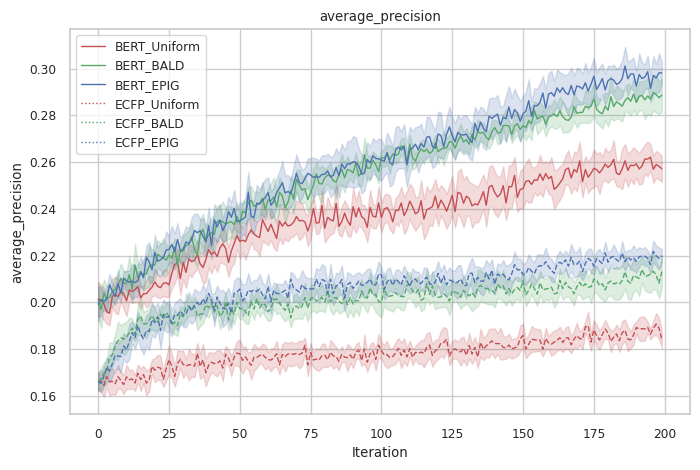

In [9]:
metrics_list = ["average_precision"]
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
sns.set(font_scale=0.8)  # crazy big
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )

for i, metric in enumerate(metrics_list):
    sns.lineplot(data = BERT_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "-", 
                palette=['r', 'g','b'], lw = 1, errorbar = "se"
                )
    

    sns.lineplot(data = ECFP_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "--", 
                palette=['r', 'g','b'], lw = 1, errorbar = "se"
                )

    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    ax.set_title(metric)

leg = ax.legend(loc = "upper left")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle(":")
leg_lines[4].set_linestyle(":")
leg_lines[5].set_linestyle(":")
ax.set_xlabel("Iteration")


#fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ECFP_average_precison.png",
#            dpi = 300)

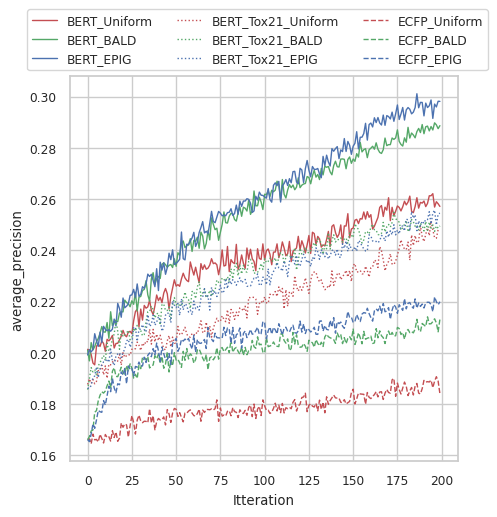

In [10]:
metrics_list = ["average_precision"]
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
sns.set(font_scale=0.8)  # crazy big
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )

for i, metric in enumerate(metrics_list):
    sns.lineplot(data = BERT_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "-", 
                palette=['r', 'g','b'], lw = 1, errorbar = None #"se"
                )
    
    sns.lineplot(data = BERT_Tox21, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "dotted", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )
    
    sns.lineplot(data = ECFP_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "--", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )

    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    #ax.set_title(metric)

leg = ax.legend(loc = "upper left")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle(":")
leg_lines[4].set_linestyle(":")
leg_lines[5].set_linestyle(":")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax.get_legend().remove()

#fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_vs_ECFP_average_precison.png",
#            dpi = 300)

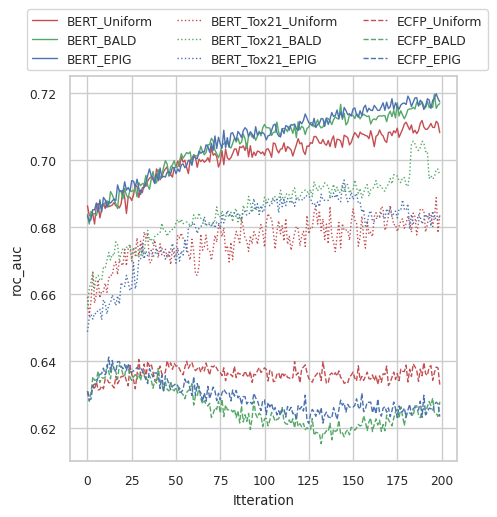

In [ ]:
metrics_list = ["roc_auc"]
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
sns.set(font_scale=0.8)  # crazy big
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )

for i, metric in enumerate(metrics_list):
    sns.lineplot(data = BERT_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "-", 
                palette=['r', 'g','b'], lw = 1, errorbar = None #"se"
                )
    
    sns.lineplot(data = BERT_Tox21, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "dotted", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )
    
    sns.lineplot(data = ECFP_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "--", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )

    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    #ax.set_title(metric)

leg = ax.legend(loc = "upper left")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle(":")
leg_lines[4].set_linestyle(":")
leg_lines[5].set_linestyle(":")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax.get_legend().remove()

fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_vs_ECFP_ROC_AUC.png",
            dpi = 300)

### ECE and ACE

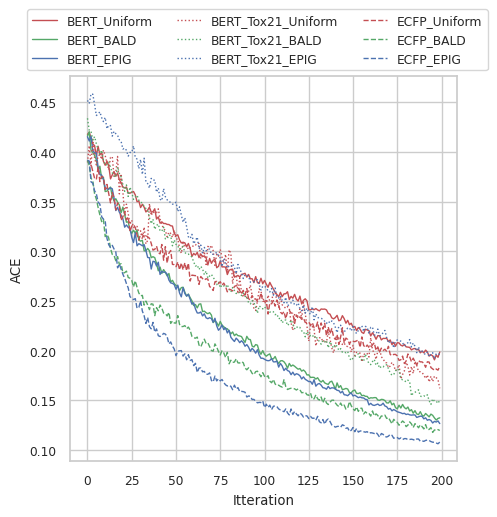

In [ ]:
metrics_list = ["ACE"]
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
sns.set(font_scale=0.8)  # crazy big
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )

for i, metric in enumerate(metrics_list):
    sns.lineplot(data = BERT_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "-", 
                palette=['r', 'g','b'], lw = 1, errorbar = None #"se"
                )
    
    sns.lineplot(data = BERT_Tox21, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "dotted", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )
    
    sns.lineplot(data = ECFP_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "--", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )

    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    #ax.set_title(metric)

leg = ax.legend(loc = "upper left")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle(":")
leg_lines[4].set_linestyle(":")
leg_lines[5].set_linestyle(":")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax.get_legend().remove()

fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_ECFP_ACE.png",
            dpi = 300)

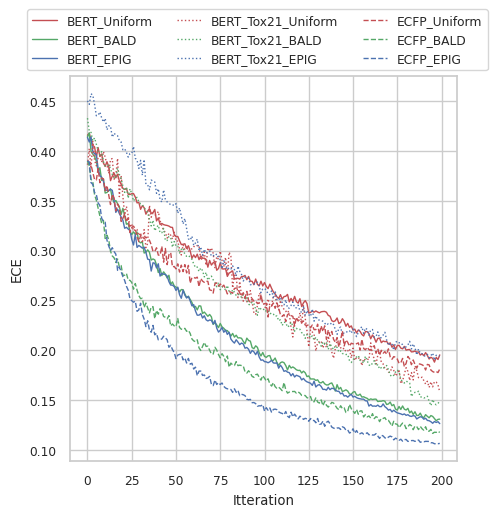

In [12]:
metrics_list = ["ECE"]
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
sns.set(font_scale=0.8)  # crazy big
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )

for i, metric in enumerate(metrics_list):
    sns.lineplot(data = BERT_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "-", 
                palette=['r', 'g','b'], lw = 1, errorbar = None #"se"
                )
    
    sns.lineplot(data = BERT_Tox21, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "dotted", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )
    
    sns.lineplot(data = ECFP_Vanilla, x = "Itteration", y = metric, 
                hue = "Acq_Func", ax = ax, linestyle = "--", 
                palette=['r', 'g','b'], lw = 1, errorbar = None#"se"
                )

    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    #ax.set_title(metric)

leg = ax.legend(loc = "upper left")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle(":")
leg_lines[4].set_linestyle(":")
leg_lines[5].set_linestyle(":")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax.get_legend().remove()

fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_ECFP_ECE.png",
            dpi = 300)

In [13]:
num_itterations = 200
BERT_Vanilla_task_wise = combine_results(config, "BERT", task_wise_mean = False)
ECFP_Vanilla_task_wise = combine_results(config, "ECFP", task_wise_mean = False)
BERT_Tox21_task_wise = combine_results(config, "BERT_Tox21", task_wise_mean = False)


NR-AR
NR-AR-LBD
NR-AhR
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53
NR-AR
NR-AR-LBD
NR-AhR
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53
NR-AR
NR-AR-LBD
NR-AhR
NR-Aromatase
NR-ER
NR-ER-LBD
NR-PPAR-gamma
SR-ARE
SR-ATAD5
SR-HSE
SR-MMP
SR-p53


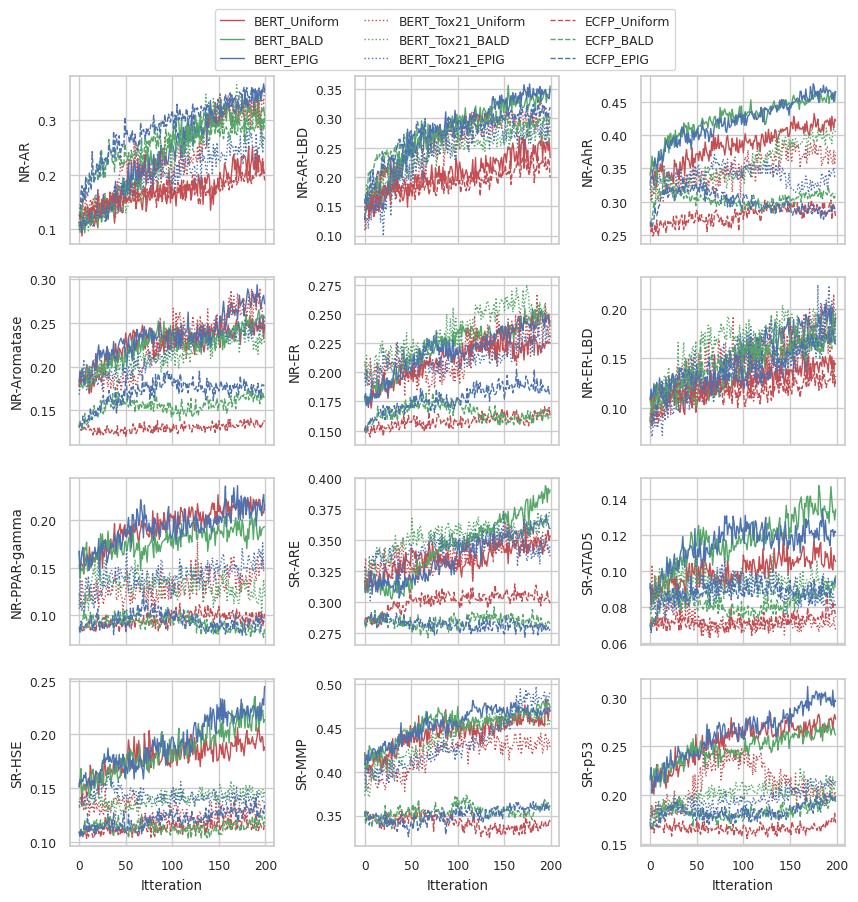

In [14]:
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
metric = ["average_precision"]
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (10,10),
                    gridspec_kw = {'wspace':0.4, 'hspace':0.2},
                    sharex = True,
                    #sharex = True
                    )

ax = axs.ravel()
task_list = BERT_Vanilla_task_wise.Tasks.unique()
for i, task in enumerate(task_list):
    data = BERT_Vanilla_task_wise[BERT_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
                #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
                palette=['r', 'g','b'], lw = 1,
                hue = "Acq_Func", linestyle = "-",
                ax = ax[i],errorbar = None #"se"
                )
    
    data = BERT_Tox21_task_wise[BERT_Tox21_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "dotted",
            ax = ax[i], errorbar = None #"se"
            )
    
    data = ECFP_Vanilla_task_wise[ECFP_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "--",
            ax = ax[i], errorbar = None #"se"
            )
    
    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    ax[i].set_ylabel(task)
    if i != 0:
        ax[i].get_legend().remove()


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax[0].get_legend().remove()

#plt.legend()
fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_ECFP_Taskwise_average_precision.png",
            dpi = 300)

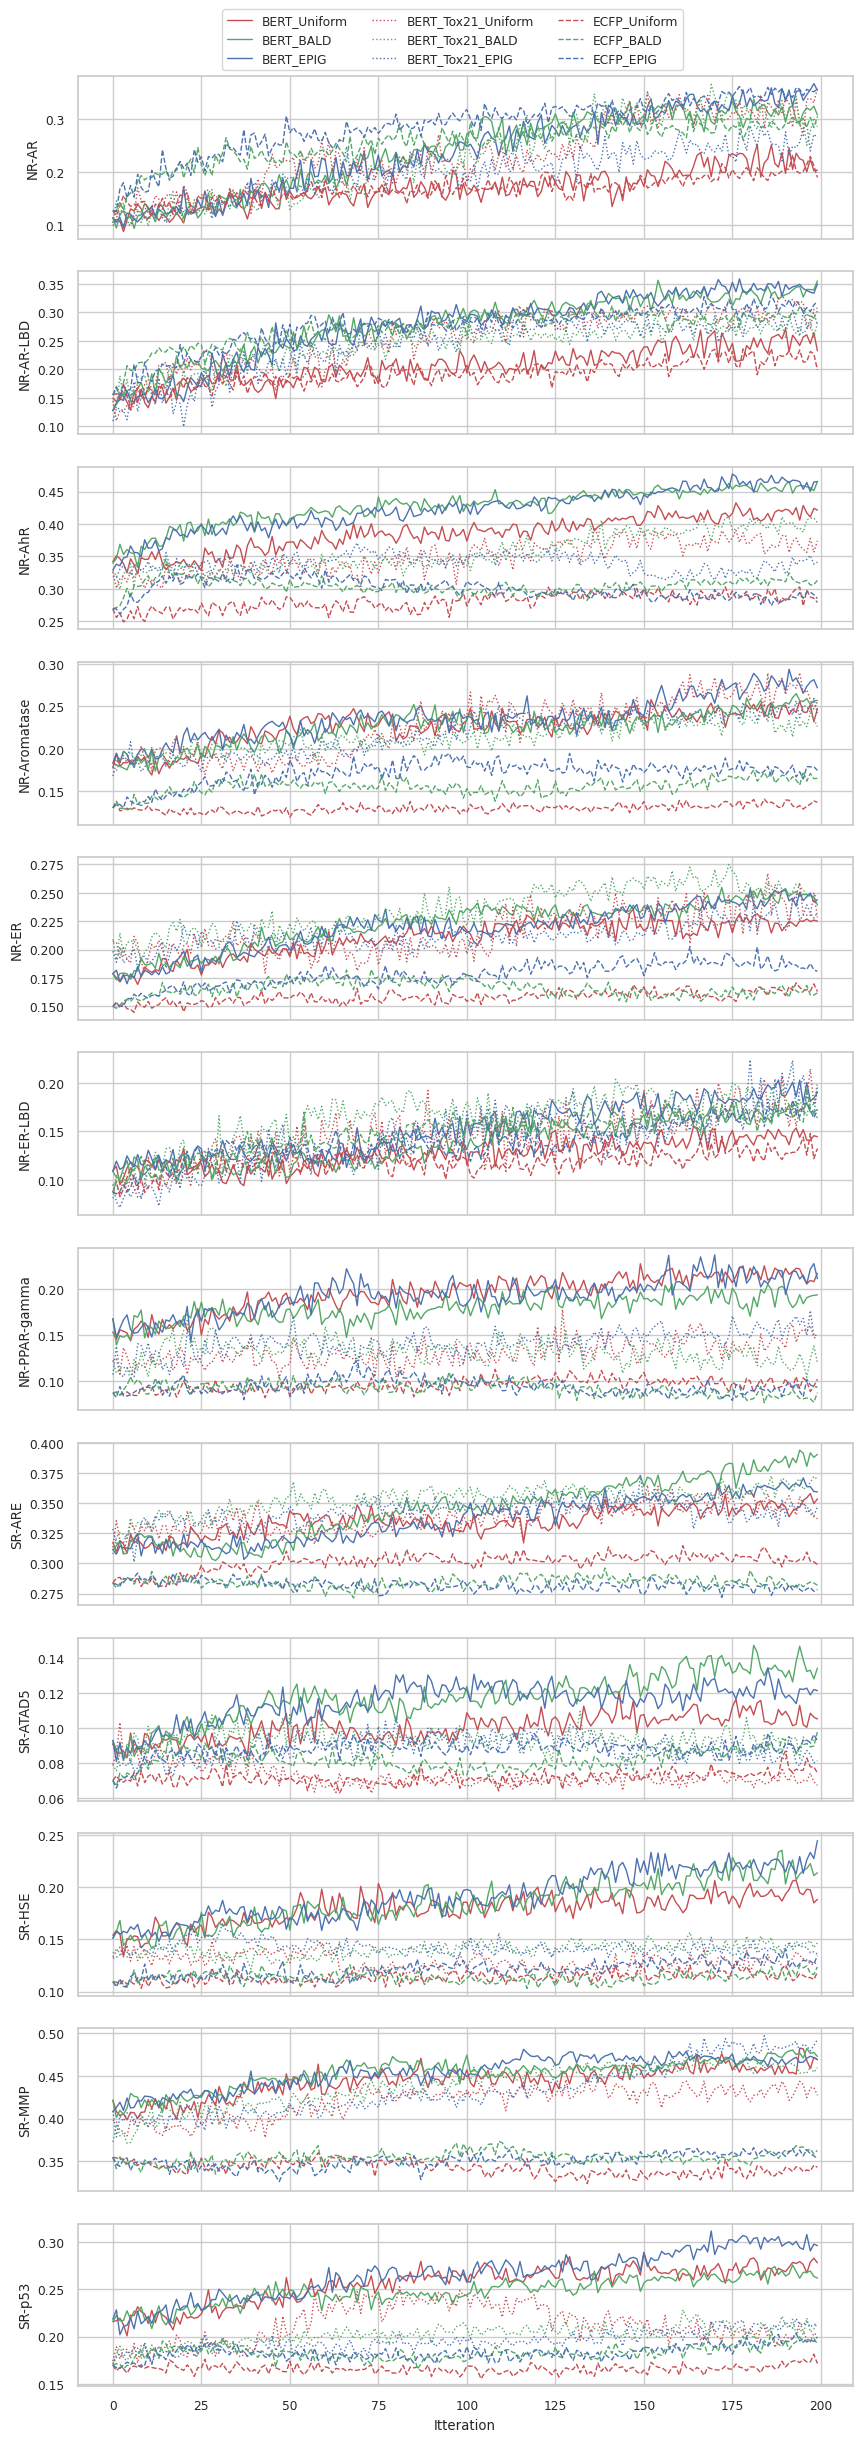

In [15]:
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
metric = ["average_precision"]
fig, axs = plt.subplots(nrows = 12, ncols = 1, figsize = (10,30),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.2},
                    sharex = True,
                    #sharex = True
                    )

ax = axs.ravel()
task_list = BERT_Vanilla_task_wise.Tasks.unique()
for i, task in enumerate(task_list):
    data = BERT_Vanilla_task_wise[BERT_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
                #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
                palette=['r', 'g','b'], lw = 1,
                hue = "Acq_Func", linestyle = "-",
                ax = ax[i],errorbar = None #"se"
                )
    
    data = BERT_Tox21_task_wise[BERT_Tox21_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "dotted",
            ax = ax[i], errorbar = None #"se"
            )
    
    data = ECFP_Vanilla_task_wise[ECFP_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "--",
            ax = ax[i], errorbar = None #"se"
            )
    
    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    ax[i].set_ylabel(task)
    if i != 0:
        ax[i].get_legend().remove()


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax[0].get_legend().remove()

#plt.legend()
fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_ECFP_Taskwise_average_precision2.png",
            dpi = 300)

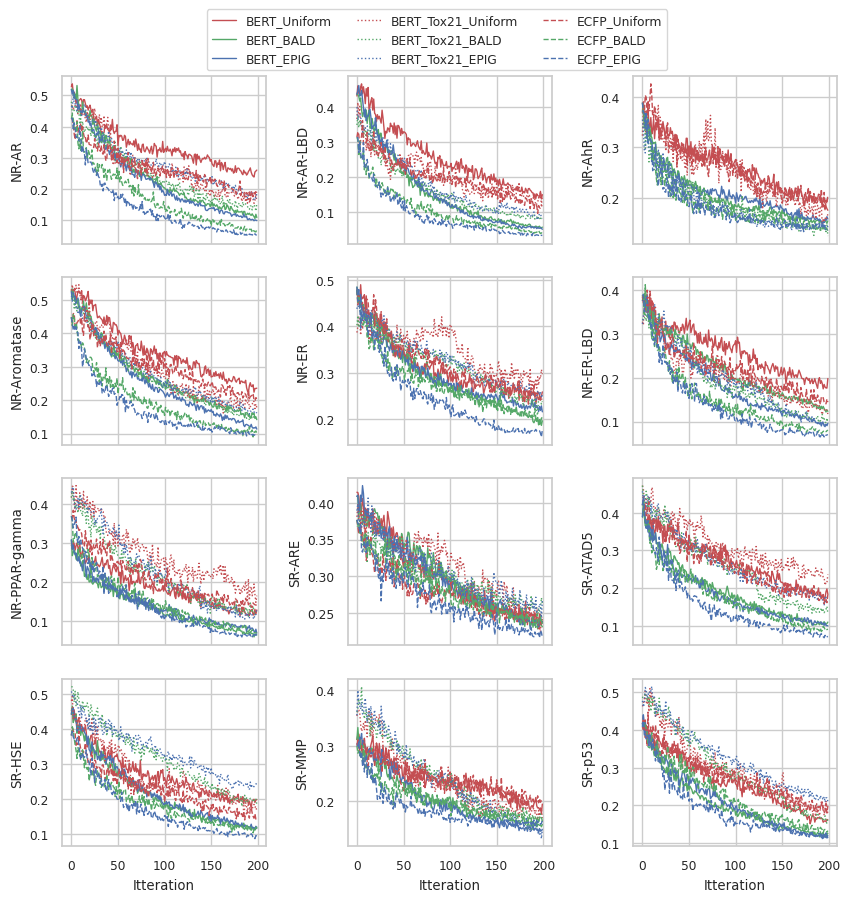

In [16]:
# ACE and ECE
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
metric = ["ACE"]
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (10,10),
                    gridspec_kw = {'wspace':0.4, 'hspace':0.2},
                    sharex = True,
                    #sharex = True
                    )

ax = axs.ravel()
task_list = BERT_Vanilla_task_wise.Tasks.unique()
for i, task in enumerate(task_list):
    data = BERT_Vanilla_task_wise[BERT_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
                #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
                palette=['r', 'g','b'], lw = 1,
                hue = "Acq_Func", linestyle = "-",
                ax = ax[i],errorbar = None #"se"
                )
    
    data = BERT_Tox21_task_wise[BERT_Tox21_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "dotted",
            ax = ax[i], errorbar = None #"se"
            )
    
    data = ECFP_Vanilla_task_wise[ECFP_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "--",
            ax = ax[i], errorbar = None #"se"
            )
    
    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    ax[i].set_ylabel(task)
    if i != 0:
        ax[i].get_legend().remove()


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax[0].get_legend().remove()

#plt.legend()
fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_ECFP_Taskwise_ACE.png",
            dpi = 300)

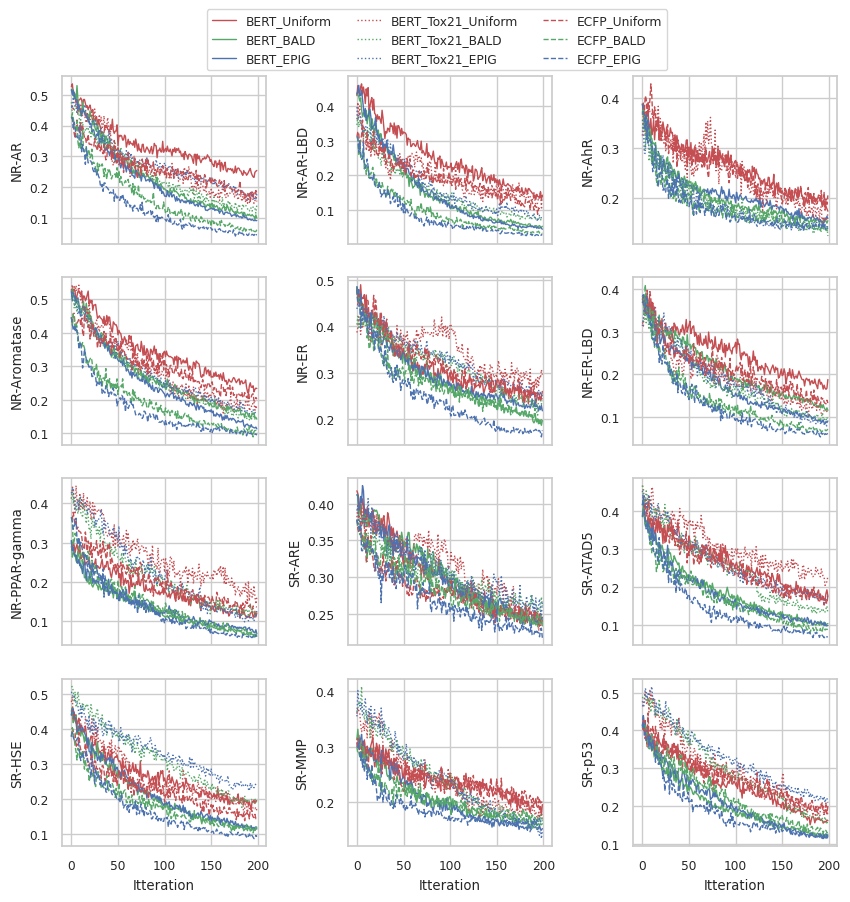

In [17]:
# ACE and ECE
#metrics_list = ["balanced_acc","f1_score","roc_auc", "average_precision"]
metric = ["ECE"]
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (10,10),
                    gridspec_kw = {'wspace':0.4, 'hspace':0.2},
                    sharex = True,
                    #sharex = True
                    )

ax = axs.ravel()
task_list = BERT_Vanilla_task_wise.Tasks.unique()
for i, task in enumerate(task_list):
    data = BERT_Vanilla_task_wise[BERT_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
                #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
                palette=['r', 'g','b'], lw = 1,
                hue = "Acq_Func", linestyle = "-",
                ax = ax[i],errorbar = None #"se"
                )
    
    data = BERT_Tox21_task_wise[BERT_Tox21_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "dotted",
            ax = ax[i], errorbar = None #"se"
            )
    
    data = ECFP_Vanilla_task_wise[ECFP_Vanilla_task_wise.Tasks == task]
    sns.lineplot(data = data, x = "Itteration", y = metric[0], 
            #hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"], 
            palette=['r', 'g','b'], lw = 1,
            hue = "Acq_Func", linestyle = "--",
            ax = ax[i], errorbar = None #"se"
            )
    
    #ax[i].axhline(y = baseline_main[metric].values, ls = '--', color = 'Red')
    ax[i].set_ylabel(task)
    if i != 0:
        ax[i].get_legend().remove()


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)
ax[0].get_legend().remove()

#plt.legend()
fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Vanilla_BERT_vs_ToxBERT_ECFP_Taskwise_ECE.png",
            dpi = 300)

# TSNE plots

In [18]:
# Representaions of molecules
### BALD_BERT_pretrained_Tox21_trainset (v2)###
config = {
"metadata_dir": '/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/',
"target_file": "/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_filtered_data.csv",
"BERT_features_file":"/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_BERT_features_pretrained_on_Tox21_trainset_epoch_675.csv"
}

In [20]:
Tox_BERT_features = pd.read_csv(config["BERT_features_file"])

SMILES         0         1  \
0                      CCOC1=CC=C2N=C(S(N)(=O)=O)SC2=C1 -0.782020 -0.758347   
1                          CCN1C(=O)NC(C2=CC=CC=C2)C1=O -0.921221 -0.765405   
2                      CCC1(O)CCC2C3CCC4=CCCCC4C3CCC21C -0.591796  0.055983   
3                    CCCN(CC)C(CC)C(=O)NC1=C(C)C=CC=C1C -0.891799 -0.827370   
4                             CC(O)(P(=O)(O)O)P(=O)(O)O  0.646970  0.524931   
...                                                 ...       ...       ...   
7496                         CCCN1C(=O)NC(=O)C2=C1N=CN2 -0.921676 -0.871827   
7497           CCCNCC(O)COC1=CC=CC=C1C(=O)CCC1=CC=CC=C1 -0.508779 -0.492217   
7498  CCOC1=NC2=CC=CC(C(=O)O)=C2N1CC1=CC=C(C2=CC=CC=... -0.253643 -0.441990   
7499           CC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C -0.759435 -0.526362   
7500        COC1=CC=C2CC3C4=CC5=C(C=C4CCN3CC2=C1OC)OCO5 -0.417653 -0.050897   

             2         3         4         5         6         7         8  \
0     0.005921 -0.715358 -0.651017 -0.878225 -0.040183 -0.202353  0.426030   
1    -0.349849 -0.497505  0.638644 -0.922583 -0.091552 -0.301120 -0.475287   
2    -0.058373  0.728146 -0.296720  0.061354  0.007323 -0.375010  0.391155   
3     0.204449  0.311193  0.814942 -0.686310  0.334014 -0.658762 -0.591908   
4    -0.138341 -0.688308  0.561677  0.227628 -0.697897  0.237184 -0.005327   
...        ...       ...       ...       ...       ...       ...       ...   
7496  0.211465 -0.381433 -0.296534 -0.891686 -0.568698 -0.804674 -0.110649   
7497 -0.485575  0.271625  0.401613 -0.906464  0.500454 -0.661752 -0.112065   
7498 -0.550134 -0.233906 -0.230540 -0.850986  0.008242 -0.779138  0.696013   
7499 -0.356328  0.775150 -0.199575  0.189404  0.593392 -0.359704  0.309278   
7500 -0.201606  0.641693 -0.686970 -0.881645  0.132001 -0.741571  0.751973   

      ...       758       759       760       761       762       763  \
0     ... -0.114396 -0.855554 -0.227164  0.579757  0.182520 -0.365891   
1     ...  0.156695 -0.479063 -0.245343 -0.514105  0.152998  0.148183   
2     ... -0.441867  0.107716 -0.539710 -0.160787  0.062409  0.833662   
3     ... -0.516911 -0.407822 -0.500919  0.017458  0.201378  0.063237   
4     ... -0.095648  0.002919  0.875203 -0.852414 -0.001243 -0.615184   
...   ...       ...       ...       ...       ...       ...       ...   
7496  ...  0.166066 -0.078554 -0.545500  0.228887  0.264266  0.294541   
7497  ... -0.011490  0.398332 -0.323325  0.089696 -0.243955  0.509985   
7498  ... -0.354883 -0.182672 -0.327530  0.762313 -0.637351 -0.155941   
7499  ... -0.517115  0.278822 -0.569537 -0.363014  0.140652  0.530997   
7500  ... -0.296593 -0.500950 -0.354056  0.129368 -0.044391  0.844824   

           764       765       766       767  
0    -0.825166  0.088864 -0.452293 -0.054438  
1    -0.837944  0.744371 -0.458514 -0.596826  
2    -0.281402  0.263527  0.587176 -0.092266  
3    -0.354559  0.540506 -0.073299 -0.794390  
4    -0.920940 -0.143727  0.721993 -0.250951  
...        ...       ...       ...       ...  
7496 -0.731599  0.393441  0.062484 -0.630557  
7497  0.270996 -0.211863  0.291997 -0.910273  
7498  0.325113  0.020899  0.191555 -0.826020  
7499 -0.507549  0.601402  0.590711 -0.249849  
7500  0.749253 -0.593536  0.775576  0.058428  

[7501 rows x 769 columns]

In [25]:
config = {"target_file": "/projects/home/mmasood1/arslan_data_repository/Tox21/complete_Tox21.csv",
          "Uniform_BERT_dir":"/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/uniform/",
          "BALD_BERT_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/BALD/",
          "EPIG_BERT_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/EPIG_MT/",
          
          "Uniform_ECFP_dir":"/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/ECFP/uniform/",
          "BALD_ECFP_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/ECFP/BALD/",
          "EPIG_ECFP_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/ECFP/EPIG_MT/",
          
          "Uniform_BERT_Tox21_dir":"/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/uniform/",
          "BALD_BERT_Tox21_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/BALD/",
          "EPIG_BERT_Tox21_dir": "/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/EPIG_MT/",}


In [26]:
BERT_samples = combine_samples(config, "BERT")
ECFP_samples = combine_samples(config, "ECFP")

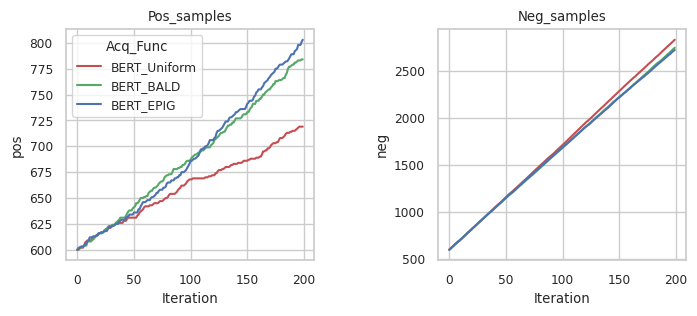

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),
                            gridspec_kw={'wspace': 0.5, 'hspace': 0.5})

BERT = BERT_samples.groupby(["Itteration","Acq_Func"]).sum(numeric_only = True).reset_index()
ECFP = ECFP_samples.groupby(["Itteration","Acq_Func"]).sum(numeric_only = True).reset_index()

# Your existing code for plotting on each subplot
ax = axs.ravel()

sns.lineplot(data=BERT, x="Itteration", y="pos", linestyle = "-",hue="Acq_Func",palette=['r', 'g','b'], 
             ax=ax[0], hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"])

sns.lineplot(data=BERT, x="Itteration", y="neg", linestyle = "-",hue="Acq_Func", palette=['r', 'g','b'], 
             ax=ax[1], hue_order = ["BERT_Uniform","BERT_BALD","BERT_EPIG"])
#sns.lineplot(data=BERT, x="Itteration", y="valid", linestyle = "-",hue="Acq_Func", ax=ax[2])


# Your existing code to remove legends from individual subplots
#ax[0].get_legend().remove()
ax[1].get_legend().remove()

# Create a single legend for the entire plot
#handles, labels = ax[2].get_legend_handles_labels()
#leg = fig.legend(handles, labels, loc='lower center', 
#                 bbox_to_anchor=(0.5, -0.2), ncol=3)
#ax[2].get_legend().remove()


# Set titles for subplots
ax[0].set_title("Pos_samples")
ax[1].set_title("Neg_samples")
#ax[2].set_title("Valid_samples")

ax[0].set_xlabel("Iteration")
ax[1].set_xlabel("Iteration")

fig.savefig("/home/mmasood1/.TG GATE/active_learning/figures/Samples_Random_vs_BALD_EPIG.png",
            dpi = 300, bbox_inches='tight')